# FIUFIP: Que No Se Escape Nadie

## Introducción

Este trabajo consiste en analizar una serie de datos recoletados por la agencia gubernamental de recaudación de impuestos *FIUFIP*.

Buscaremos entender como se relacionan estos datos y determinar un metodo de si una persona tiene **altos ingresos** o **bajos ingresos** a partir de los datos recibidos, que consisten en una serie de atributos de la persona que la agencia fue llenando y catalogando a la persona como de altos ingresos o no.



## Objetivos

**Tarea**: explicar qué conclusiones se pueden llegar a partir de analizar los datos recolectados

* Saber cómo entender cada uno de los datos
* Saber cómo se relacionan entre sí 
* Saber si se puede sacar alguna conclusión o descubrir un patrón a partir de estos

**Adicionalmente**

* Saber cuáles son los factores más importantes que determinan si un usuario **tiene altos** o **bajos ingresos** {*varible_target*}.

**Baseline**: código simple 

* intente predecir el target (si el usuario tiene **altos ingresos** o **bajos ingresos**).




## Carga de librerias y dataset

In [1]:
from collections import Counter 
import requests 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
from matplotlib import pyplot as plt
from pandas_profiling import ProfileReport

from sklearn.feature_extraction import FeatureHasher
from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import (
    KBinsDiscretizer,
    LabelEncoder,
    MinMaxScaler,
    Normalizer,
    OneHotEncoder,
    OrdinalEncoder,
    PowerTransformer,
    RobustScaler,
    StandardScaler,
)

Tambien leemos el dataset, que está en formato CSV desde Google Drive.

In [2]:
with requests.get(
    "https://docs.google.com/spreadsheets/d/1-DWTP8uwVS-dZY402-dm0F9ICw_6PNqDGLmH0u8Eqa0/export?format=csv"
) as r, open("fiufip_dataset.csv", "wb") as f:
    for chunk in r.iter_content():
        f.write(chunk)
        import pandas as pd


In [3]:
df = pd.read_csv("fiufip_dataset.csv")

# Ser contribuyente y proveer todos los datos a FIUFIP puede volverse complicado ¿Hay datos que falten en el dataset provisto?


Por ser una base de datos de la agencia FIUFIP, es posible que algunos contribuyentes hayan decido no responder o responder erroneamente a la hora de exponer sus datos personales. Esto puede llevar a que haya datos faltantes. Veamos si hay datos faltantes y ya que estamos visualicemos todas las features provistas en el dataset

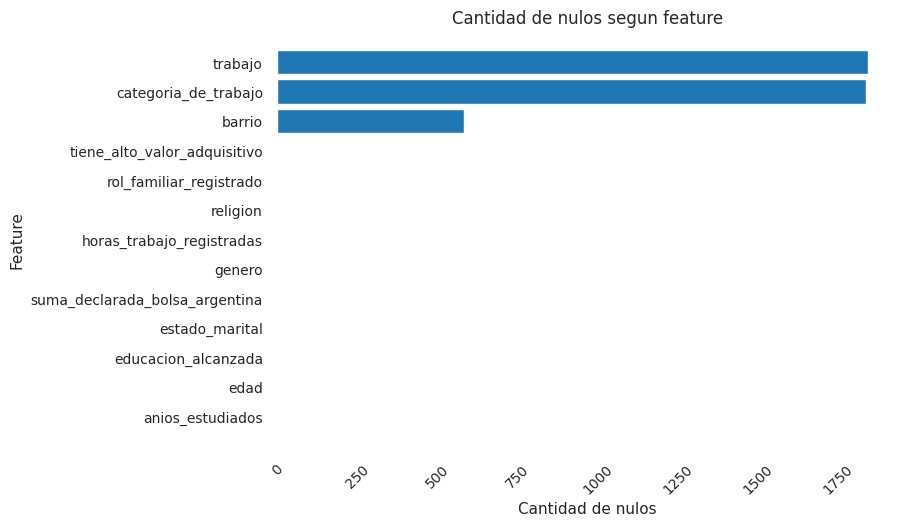

In [4]:
plt.figure(dpi = 100)
df.rename(columns={'ganancia_perdida_declarada_bolsa_argentina':'suma_declarada_bolsa_argentina'},inplace=True)
nulos = df.isnull().sum().sort_values(ascending = True)


y_pos = np.arange(len(nulos.index))
plt.barh(y_pos, nulos.values, align='center')
plt.yticks(y_pos, nulos.index)
plt.ylabel('Feature')
plt.xlabel('Cantidad de nulos')
plt.xticks(rotation = 45)
plt.title('Cantidad de nulos segun feature')
plt.show()

Se pueden observar todas las features provistas. En particular solo tres de ellas presentan valores nulos. Resulta llamativo que los nulos en categoria de trabajo y trabajo sean similiares pero primero veamos sucede con la feature barrio 

## ¿Qué sucede y cómo se distribuye la feature barrio? ¿A qué puede deberse su cantidad de valores nulos?

Veamos la cantidad de posibles opciones de barrio que hay en el dataset

In [5]:
len(df.barrio.value_counts().index)


41

Lo primero a destacar es que hay 41 barrios mientrás que Capital Federal tiene 48, luego los datos faltantes podrían deberse a que no estaban todas las opciones disponibles al momento de obtener los datos. Debido a esto cambiemos el Nan por 'Otro' y veamos la distribución de la feature en cuestión

[]

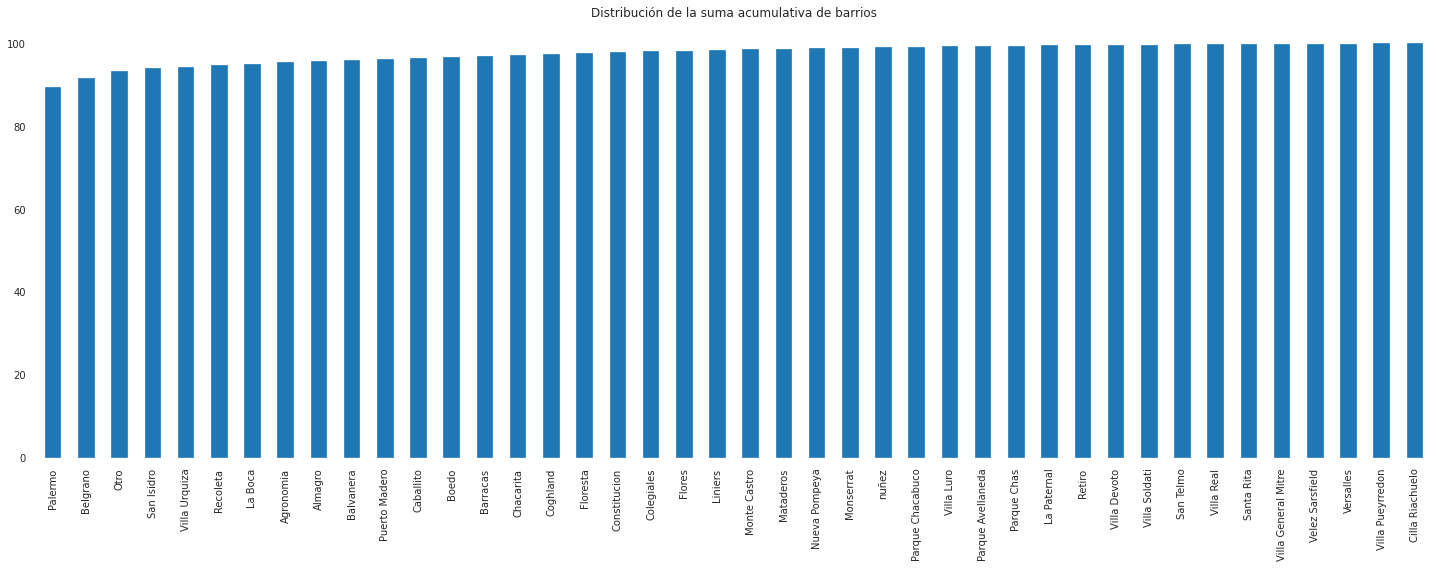

In [6]:
df['barrio'] = df['barrio'].replace(np.nan,'Otro')
barrios = df['barrio'].value_counts(normalize=True,dropna=False) * 100

barrios.cumsum().plot(
   kind='bar', title="Distribución de la suma acumulativa de barrios", figsize=(25, 8)
)
plt.plot()

De este gráfico, podemos observar que casi el 90% de los contribuyentes vive en el barrio de Palermo. Es decir, que se trata de una feature que además de tener una alta cardinaliad, tiene una baja varianza y a priori pareciera dificil poder establecer relaciones con otras variables

## ¿Qué sucede con los valores nulos en las features 'categoría de trabajo' y 'trabajo'? ¿Tiene alguna relación?

Como habiamos mencionado anteriormente, la cantidad de nulos en estas features es de un número parecido. Veamos si existe alguna relación que se pueda observar. En primer lugar veamos la feature categoria de trabajo

In [7]:
df['categoria_de_trabajo'].value_counts(dropna=False)

relacion_de_dependencia    22696
monotibutista               2541
empleado_municipal          2093
NaN                         1836
empleado_provincial         1298
responsable_inscripto       1116
empleadao_estatal            960
trabajo_voluntariado          14
sin_trabajo                    7
Name: categoria_de_trabajo, dtype: int64

Remplacemos el Nan por un 'No contesta' para poder entender mejor los datos, ya que estamos hablando de una variable categorica. Por otra parte,   se observa una distinción entre los distintos tipos de empleado público posible. Reasignemolos a una nueva categoria 'empleado_publico' y veamos la distribución de esta feature

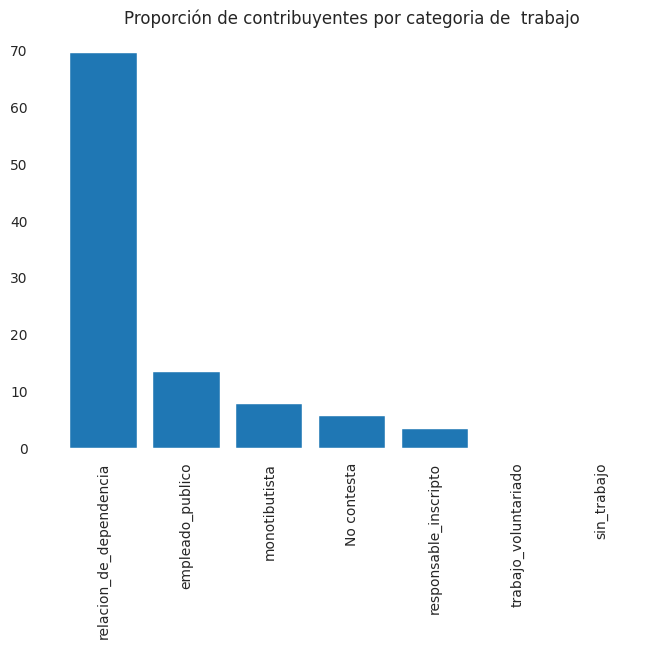

In [8]:
def generalizar_empleados_publicos(categoria):
    if categoria in ['empleado_municipal','empleado_provincial','empleadao_estatal']:
        return 'empleado_publico'
    return categoria
df['categoria_de_trabajo'] = df['categoria_de_trabajo'].replace(np.nan,'No contesta')
df['categoria_de_trabajo'] = df['categoria_de_trabajo'].apply(generalizar_empleados_publicos)
plt.figure(dpi = 100)
cantidad_por_trabajo = df['categoria_de_trabajo'].value_counts(normalize=True) * 100
plt.bar(cantidad_por_trabajo.index,cantidad_por_trabajo.values)
plt.title("Proporción de contribuyentes por categoria de  trabajo")
plt.xticks(rotation = 90)
plt.show()

Vemos que la gran mayoria de los contribuyentes se encuentra trabajando en el sector privado y en particular casi el 70% lo hace en relación de dependencia. Quizás en un futuro esta información nos sea útil, pero por el momento sigamos adelante. Veamos ahora la feature trabajo

In [9]:
df['trabajo'].value_counts(dropna=False)

profesional_especializado    4140
reparador                    4099
directivo_gerente            4066
entretenimiento              3770
ventas                       3650
otros                        3295
inspector                    2002
NaN                          1843
transporte                   1597
limpiador                    1370
sector_primario               994
soporte_tecnico               928
seguridad                     649
servicio_domestico            149
ejercito                        9
Name: trabajo, dtype: int64

Podemos observar que no figura entre las posibles opciones estar desempleado, con lo cual quizas no estaba la opción a la hora de la construcción del dataset. Remplacemos los NaN por 'No contesta' y luego veremos si podemos obtener más información de quienes no contestaron

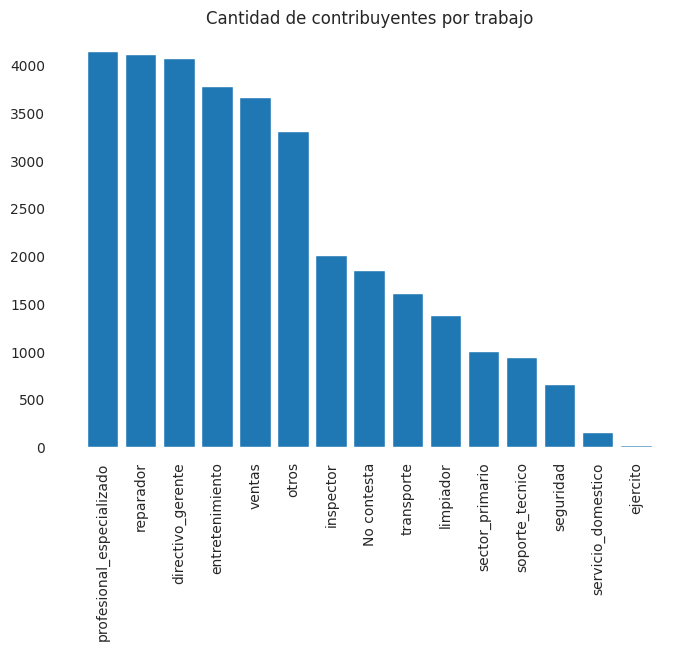

In [10]:
df['trabajo'] = df['trabajo'].replace(np.nan,'No contesta')
plt.figure(dpi = 100)
cantidad_por_trabajo = df['trabajo'].value_counts()
plt.bar(cantidad_por_trabajo.index,cantidad_por_trabajo.values)
plt.title("Cantidad de contribuyentes por trabajo")
plt.xticks(rotation = 90)
plt.show()

La distribución no pareciera tener nada llamativo en si, salvo de nuevo por la cantidad que no contesta.

In [11]:
dataset_sin_contestar = df[df['categoria_de_trabajo'] == 'No contesta']
dataset_sin_contestar = dataset_sin_contestar[dataset_sin_contestar['trabajo'] == 'No contesta']
dataset_sin_contestar.shape

(1836, 13)

Se puede ver que trás filtrar el dataset por aquellos contribuyentes de los que no se tiene datos, de quienes no se sabe su trabajo, tampoco se sabe su categoria. Ahora bien, ¿Se trata esto de un error en la recolección de los datos por parte de nuestra querida agencia? ¿Se tratará de desempleados que erronamente figuran en el dataset? ¿O son desempleados (quizás retirados) que conservan fuentes de ingreso que son gravables? 

## Aquellos de quienes desconocemos su trabajo,  ¿Operan en la bolsa?¿Qué edades tienen? ¿Presentan horas registradas trabajando?

Veamos primero si que edades en tienen

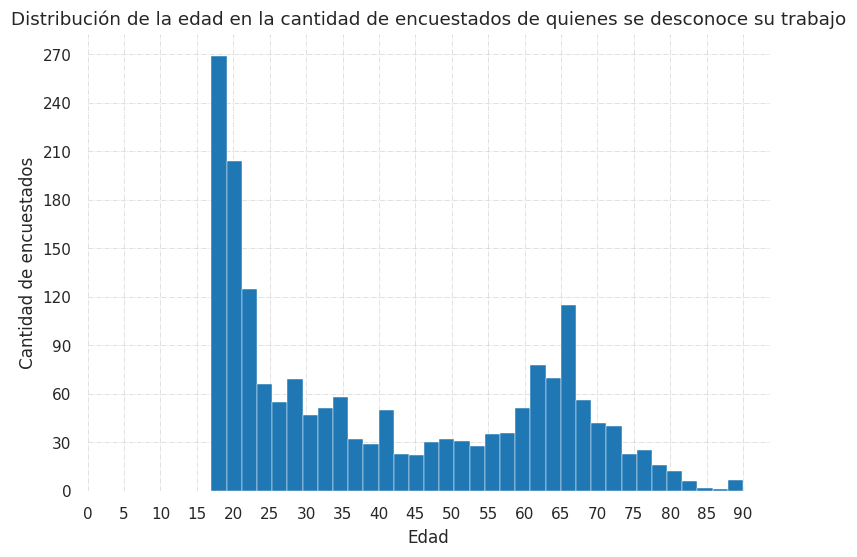

In [12]:
plt.figure(dpi=110)
bins_deseados = int(dataset_sin_contestar.edad.nunique()/2)
plt.hist(dataset_sin_contestar.edad, bins=bins_deseados, label="Edad")

plt.title("Distribución de la edad en la cantidad de encuestados de quienes se desconoce su trabajo")
plt.ylabel("Cantidad de encuestados")
plt.xlabel("Edad")
plt.xticks(np.arange(0,95, 5))
plt.yticks(np.arange(0,300, 30))
plt.grid(b = True, color ='grey', linestyle ='-.', linewidth = 0.5, alpha = 0.3)

plt.show()

No resulta llamativo una cierta concentración a partir de aproximadamente contribuyentes mayores a 60 años (pueden ser jubilados con bienes adicionales que sean gravables), pero ¿como se puede explicar la concentración que vemos en los sub 30? Investiguemos un poco más, quizás hemos identificado a genios del trading, que aún así no lograron evadir las garras de la FIUFIP

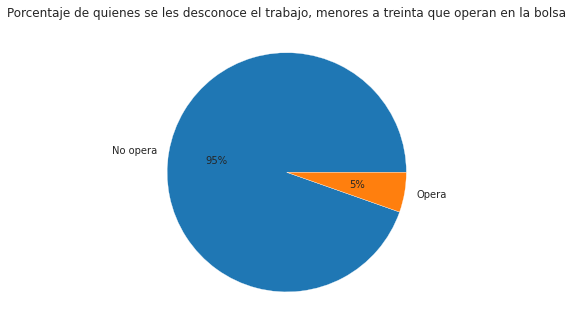

In [35]:
menores_a_treinta = dataset_sin_contestar[dataset_sin_contestar['edad'] <= 30]
porcentaje_que_opera = (menores_a_treinta['suma_declarada_bolsa_argentina'] != 0).value_counts(normalize=True)
porcentaje_que_opera.plot(kind='pie',autopct='%1.0f%%',labels = ['No opera','Opera'])
plt.title('Porcentaje de quienes se les desconoce el trabajo, menores a treinta que operan en la bolsa')
plt.ylabel('')
plt.show()


Bueno, pareciera que no se trata particularmente de genios de las finanzas, o al menos no de gente que tiene interés en comunicarlo. Veamos por último, que sucede con la feature horas trabajas

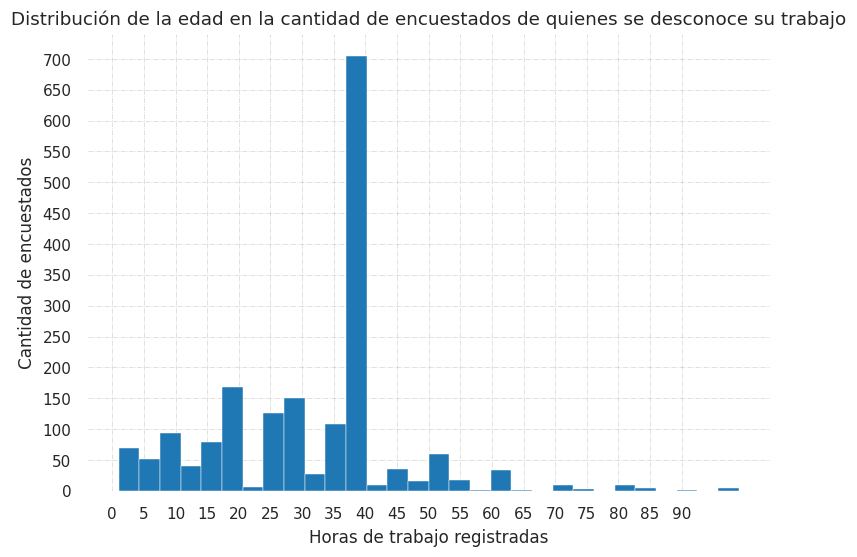

In [40]:
plt.figure(dpi=110)
bins_deseados = int(dataset_sin_contestar.horas_trabajo_registradas.nunique()/2)
plt.hist(dataset_sin_contestar.horas_trabajo_registradas, bins=bins_deseados, label="Edad")

plt.title("Distribución de la edad en la cantidad de encuestados de quienes se desconoce su trabajo")
plt.ylabel("Cantidad de encuestados")
plt.xlabel("Horas de trabajo registradas")
plt.xticks(np.arange(0,95, 5))
plt.yticks(np.arange(0,750, 50))
plt.grid(b = True, color ='grey', linestyle ='-.', linewidth = 0.5, alpha = 0.3)

plt.show()

Los datos resultan concluyentes. No parece tratarse de desempleados (a menos que acaben de perder el empleo y estos datos aún no se hayan actualizado) sino más bien de la que realmente no se tiene información. Habrá que mejorar la recolección de datos hecha por FIUFIP. Por su incertidumbre, vamos a optar por descartar estos contribuyentes. **DUDOSO**

# Se puede mentir con la edad en las redes, en persona, pero ... ¿Y a la FIUFIP?

Resulta de interés observar la distribución de edades de los contribuyentes. Reagrupemos en rangos y observemos

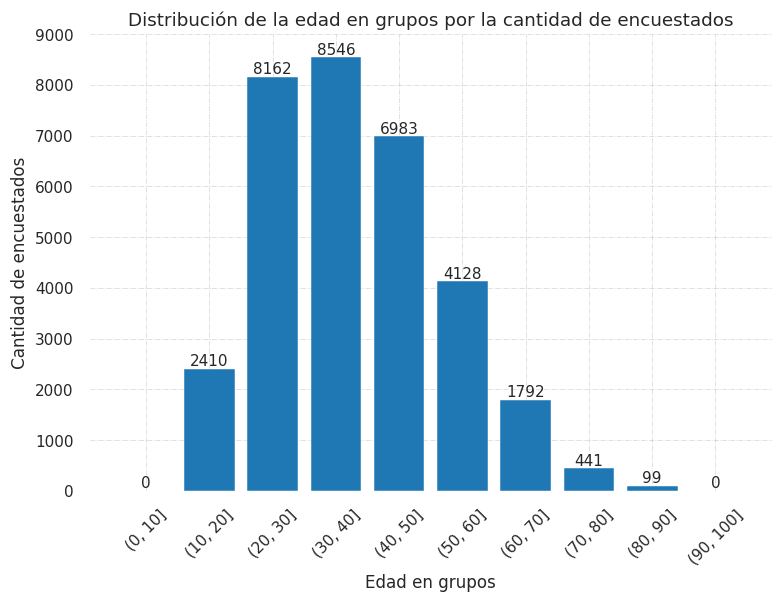

In [41]:
fig, ax = plt.subplots(dpi=110)
    
rango_edades =  np.arange(0,110,10)
cantidad_en_rango = pd.Series(pd.cut(df['edad'], bins = rango_edades).value_counts()).sort_index()

ploted = plt.bar(cantidad_en_rango.index.astype(str), cantidad_en_rango.values)

for rect in ploted:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2., height,
            '%d' % int(height),
            ha='center', va='bottom')

plt.title("Distribución de la edad en grupos por la cantidad de encuestados")
plt.ylabel("Cantidad de encuestados")
plt.xlabel("Edad en grupos")
plt.grid(b = True, color ='grey', linestyle ='-.', linewidth = 0.5, alpha = 0.3)
plt.tick_params('x',labelrotation=45)
plt.yticks(np.arange(0,9500, 1000))
plt.show()

Justo como lo sospechabamos, hay una mayor cantidad de contribuyentes en el rango de los 20 años a los 50 años. Era esperable, se trata de los años donde la gran de las personas realiza su vida profesional. Ahora bien, las mujeres tienen la posibilidad de jubilarse antes, ¿Se ve esto reflejado en los datos? Antes de contestar esta pregunta, veamos un poco la distribución del género

## Edad y horas trabajadas ¿Alguna relación con la categoria de trabajo?

La lógica indica que con el paso de los años, se tiende a trabajar menos. O al menos esperamos que sea asi. Veamos si hallamos una relación

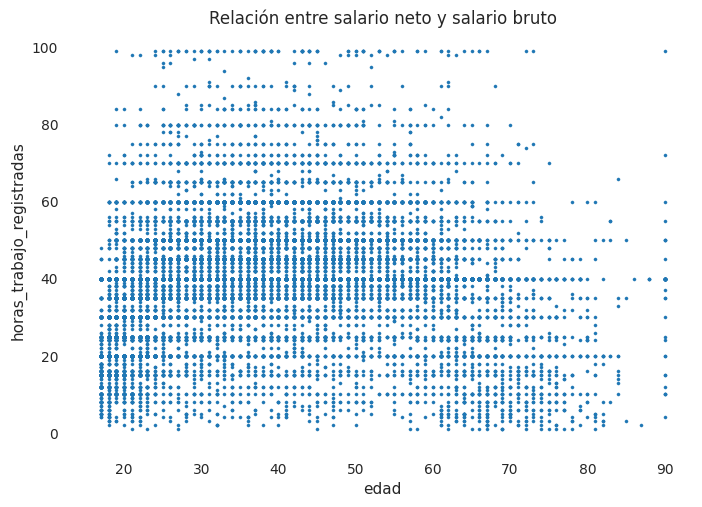

In [53]:
plt.figure(dpi=(100))
plt.scatter(
    x=df['edad'],
    y=df['horas_trabajo_registradas'],
    s=5,
)
plt.ylabel("horas_trabajo_registradas")
plt.xlabel("edad")
plt.title('Relación entre salario neto y salario bruto')
plt.show()

## ¿Como es la distribución en cuanto al género de los contribuyentes?

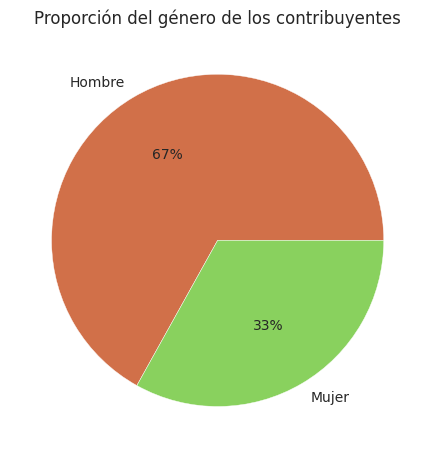

In [45]:
plt.figure(dpi=100)
cantidad_por_genero = df.genero.value_counts(normalize=True)
cantidad_por_genero.plot(kind='pie',labels= ['Hombre', 'Mujer'],colors=['#D17049',"#89D15E"],autopct='%1.0f%%')
plt.title('Proporción del género de los contribuyentes')
plt.ylabel('')
plt.show()



Se observa una mayor cantidad de hombres. Una posible explicación, podria ser que, aún en los tiempos que corren, las mujeres continuan realizando mayormente tareas domesticas no remuneradas que les impide trabajar. Ahora bien, volviendo a lo anterior, ¿Qué sucede con la edad y el género?

## Edad y Género ¿Alguna ventaja para las mujeres?

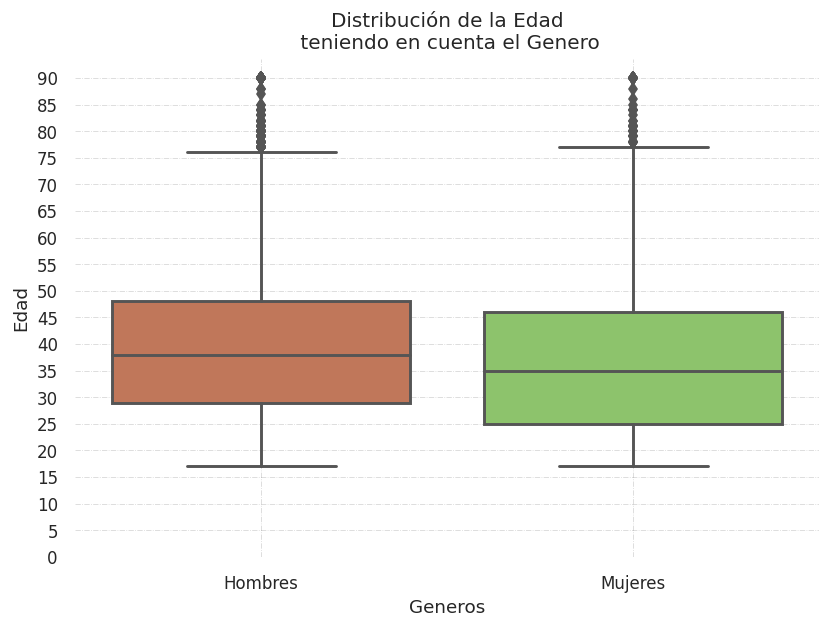

In [47]:
plt.figure(dpi=120)
plt.title("Distribución de la Edad\n teniendo en cuenta el Genero")
sns.boxplot(
    data=df,
    y='edad',
    x='genero',
    palette=['#D17049', "#89D15E"],
)
plt.ylabel("Edad")
plt.xlabel("Generos")
plt.xticks([False, True], ["Hombres", "Mujeres"])
plt.yticks(np.arange(0,95, 5))
plt.grid(b = True, color ='grey', linestyle ='-.', linewidth = 0.5, alpha = 0.3)

plt.show()

# ¿Como son los niveles de educacion alcanzados?


### ¿Como se relaciona la cantidad de años estudiados segun el nivel de educacion alcanzada?

### ¿Hay equitatividad por genero en los niveles de educacion alcanzados?

# ¿Qué sucede con la educación de los encuestados?  

Texto

Conclusion

## ¿Hay alguna relacion la religion?

TExto

Conlcusion
